# Plotting Rooflines from Counters

Brian Gravelle
October 2020

LANL

gravelle@lanl.gov

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 0) # don't truncate columns
pd.set_option("display.max_colwidth", 0) # don't truncate column values



# Roofline Plot instructions


### Getting the data from ERT:

After running the ert to your satisfaction on your target system,you can look
in the results directory under Run.00X and locate a roofline.gnu file. This file
is a script for gnuplot to make the ert plots and holds the data we need to make
our roofline plots.

Pull the data from the roofline.gnu plot file (example below). Note that your
file may have additional spots for mre cache levels. Adding additional levels 
should be easy, but we recommend reworking your ERT config if more than 3 
appear. These lines appear near the bottom of the file.

#### gnuplot format:
     
     set label '[peak FLOPs] GFLOPs/sec (Maximum)' at 2.0000000e+00,3.3952560e+03 left textcolor rgb '#000080'
     set label 'L1 - [L1 slope] GB/s' at 4.6924019e-02,4.6870291e+02 left rotate by 45 textcolor rgb '#800000'
     set label 'L2 - [L2 slope] GB/s' at 6.8638376e-02,3.2042460e+02 left rotate by 45 textcolor rgb '#800000'
     set label 'DRAM - [ext mem slope] GB/s' at 2.655384e-01,6.438239e+01 left rotate by 45 textcolor rgb '#800000'
     plot \
     (x <= [L1 max AI (corner)] ? 8.2550000e+03 * x : 1/0) lc 1 lw 2,\
     (x <= [L2 max AI (corner)] ? 3.8581000e+03 * x : 1/0) lc 1 lw 2,\
     (x <= [Ext Mem max AI (corner)] ? 2.0038000e+02 * x : 1/0) lc 1 lw 2,\
     (x >= [starting point for peak] ? 2.8293800e+03 : 1/0) lc 3 lw 2

#### gnuplot example:
     
     set label '2829.4 GFLOPs/sec (Maximum)' at 2.0000000e+00,3.3952560e+03 left textcolor rgb '#000080'
     set label 'L1 - 8255.0 GB/s' at 4.6924019e-02,4.6870291e+02 left rotate by 45 textcolor rgb '#800000'
     set label 'L2 - 3858.1 GB/s' at 6.8638376e-02,3.2042460e+02 left rotate by 45 textcolor rgb '#800000'
     set label 'DRAM - 200.4 GB/s' at 2.6553840e-01,6.4382388e+01 left rotate by 45 textcolor rgb '#800000'
     plot \
     (x <= 3.4274743e-01 ? 8.2550000e+03 * x : 1/0) lc 1 lw 2,\
     (x <= 7.3336098e-01 ? 3.8581000e+03 * x : 1/0) lc 1 lw 2,\
     (x <= 1.4120072e+01 ? 2.0038000e+02 * x : 1/0) lc 1 lw 2,\
     (x >= 3.4274743e-01 ? 2.8293800e+03 : 1/0) lc 3 lw 2


### Making the roofline

Grabbing the data as described above, you can fill it in to the below variables.
Note that you may need to comment out some of the lines depending on how many caches are available on your system.

In [4]:
peak = 1915.1

L1_corner  = 3.5881990e-01
L1_slope   = 5337.2
L1_inter   = peak - L1_slope*L1_corner
L2_corner  = 6.1713591e-01
L2_slope   = 3103.2
L2_inter   = peak - L2_slope*L2_corner
# L3_corner  = 0
# L3_slope   = 0
# L3_inter   = peak - L3_slope*L3_corner
mem_corner = 1.4896469e+01
mem_slope  = 128.6
mem_inter  = peak - mem_slope*mem_corner

# peak_start = mem_corner
peak_start = L1_corner
peak_ai = np.arange(peak_start, 500.0, 0.01)
L1_ai   = np.arange(0.01, L1_corner, 0.01)
L2_ai   = np.arange(0.01, L2_corner, 0.01)
# L3_ai   = np.arange(0.01, L3_corner, 0.01)
mem_ai  = np.arange(0.01, mem_corner, 0.01)

peak_GFlops = [ peak for ai in peak_ai]
L1_GFlops = [ L1_slope*ai+L1_inter for ai in L1_ai]
L2_GFlops = [ L2_slope*ai+L2_inter for ai in L2_ai]
# L3_GFlops = [ L3_slope*ai+L3_inter for ai in L3_ai]
mem_GFlops = [ mem_slope*ai+mem_inter for ai in mem_ai]

### Adding the dots

The list below details the dots that get added to the roofline. Each dot represents a different version of the application so the user can compare how changes to the application impact performance.

In [11]:
dot_li = []

# points are ai, flop (total across threads), time (s), cycles (max or avg across threads), label

point_1 = (2.7502, 9641082400, 1.419924, 18200000000, "p2z niter 5 g++")
point_2 = ( 2.7737, 9426968500, 1.290915, 14724477000, "p2z niter 5 g++ 9")
point_3 = ( 2.6895, 27517220000, 2.7753, 10, "p2z niter 10 g++ 9")
point_4 = (2.69, 55084267000, 5.7467, 10, "p2z niter 20 g++ 9")
point_5 = (0.0415, 204105936, 0.4173, 10, "p2z niter 5 intel 19")
point_6 = (0.0411, 823269711, 1.7465, 10, "p2z niter 20 intel 19")

# point_d = (0.181214, 249100000000 , 61.42662, 59031371862.7, "mm mpi 5000 simd base")
# point_e = (0.23877, 249100000000 , 15.451311, 23694893425.2, "mm mpi 5000 simd transpose")

# points are ai, gflops, flopc, dot, label
dot_li.append((point_1[0], (point_1[1]/point_1[2])/1e9, (point_1[1]/point_1[3]), 'yo', point_1[4]))
dot_li.append((point_2[0], (point_2[1]/point_2[2])/1e9, (point_2[1]/point_2[3]), 'go', point_2[4]))
dot_li.append((point_3[0], (point_3[1]/point_3[2])/1e9, (point_3[1]/point_3[3]), 'bo', point_3[4]))
dot_li.append((point_4[0], (point_4[1]/point_4[2])/1e9, (point_4[1]/point_4[3]), 'ro', point_4[4]))
dot_li.append((point_5[0], (point_5[1]/point_5[2])/1e9, (point_5[1]/point_5[3]), 'ys', point_5[4]))
dot_li.append((point_6[0], (point_6[1]/point_6[2])/1e9, (point_6[1]/point_6[3]), 'gs', point_6[4]))
# dot_li.append((point_7[0], (point_7[1]/point_7[2])/1e9, (point_7[1]/point_7[3]), 'bo', point_7[4]))
# dot_li.append((point_8[0], (point_8[1]/point_8[2])/1e9, (point_8[1]/point_8[3]), 'bo', point_8[4]))
# dot_li.append((point_9[0], (point_9[1]/point_9[2])/1e9, (point_9[1]/point_9[3]), 'bo', point_9[4]))
# dot_li.append((point_a[0], (point_a[1]/point_a[2])/1e9, (point_a[1]/point_a[3]), 'bo', point_a[4]))
# dot_li.append((point_b[0], (point_b[1]/point_b[2])/1e9, (point_b[1]/point_b[3]), 'bo', point_b[4]))
# dot_li.append((point_c[0], (point_c[1]/point_c[2])/1e9, (point_c[1]/point_c[3]), 'bo', point_c[4]))

# dot_li.append((point_d[0], (point_d[1]/point_d[2])/1e9, (point_d[1]/point_d[3]), 'go', point_d[4]))
# dot_li.append((point_e[0], (point_e[1]/point_e[2])/1e9, (point_e[1]/point_e[3]), 'ro', point_e[4]))

for dot in dot_li:
    print(dot)

(2.7502, 6.789858048740637, 0.5297298021978022, 'yo', 'p2z niter 5 g++')
(2.7737, 7.30254780523892, 0.6402243353023677, 'go', 'p2z niter 5 g++ 9')
(2.6895, 9.915043418729505, 2751722000.0, 'bo', 'p2z niter 10 g++ 9')
(2.69, 9.585373692728, 5508426700.0, 'ro', 'p2z niter 20 g++ 9')
(0.0415, 0.48911079798705964, 20410593.6, 'ys', 'p2z niter 5 intel 19')
(0.0411, 0.4713826000572574, 82326971.1, 'gs', 'p2z niter 20 intel 19')


### Plotting the Roofline

This block runs the plotting of the above inputs.

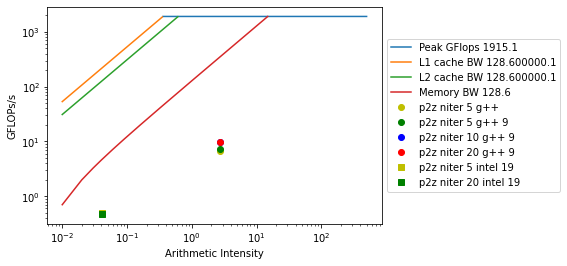

In [12]:
fig = plt.figure()
roof = fig.add_subplot(1, 1, 1)
roof.loglog(peak_ai, peak_GFlops, label=("Peak GFlops %.1f"%peak))
roof.loglog(L1_ai, L1_GFlops, label=("L1 cache BW %f.1"%mem_slope))
roof.loglog(L2_ai, L2_GFlops, label=("L2 cache BW %f.1"%mem_slope))
# roof.loglog(L3_ai, L3_GFlops, label=("L3 cache BW %f.1"%mem_slope))
roof.loglog(mem_ai, mem_GFlops, label=("Memory BW %.1f"%mem_slope))
roof.set_ylabel('GFLOPs/s')
roof.set_xlabel('Arithmetic Intensity')

for dot in dot_li:
    roof.loglog(dot[0],dot[1],dot[3],label=dot[4])

temp = roof.legend(loc="center left", bbox_to_anchor=(1.0,0.5))

#### Using flops per cycle here

SVE 512 would be 8 flops per core per cycle which is 384 (768 with FMA) total

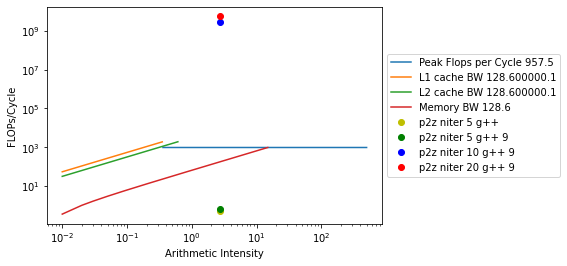

In [15]:
freq = 2.0 # GHz
peak_GFlopc = [ p/freq for p in peak_GFlops]
mem_GFlopc = [ p/freq for p in mem_GFlops]

fig = plt.figure()
roof = fig.add_subplot(1, 1, 1)
roof.loglog(peak_ai, peak_GFlopc, label=("Peak Flops per Cycle %.1f"%peak_GFlopc[0]))
roof.loglog(L1_ai, L1_GFlops, label=("L1 cache BW %f.1"%mem_slope))
roof.loglog(L2_ai, L2_GFlops, label=("L2 cache BW %f.1"%mem_slope))
# roof.loglog(L3_ai, L3_GFlops, label=("L3 cache BW %f.1"%mem_slope))
roof.loglog(mem_ai, mem_GFlopc, label=("Memory BW %.1f"%mem_slope))
roof.set_ylabel('FLOPs/Cycle')
roof.set_xlabel('Arithmetic Intensity')

for dot in dot_li:
    roof.loglog(dot[0],dot[2],dot[3],label=dot[4])

temp = roof.legend(loc="center left", bbox_to_anchor=(1.0,0.5))